In [ ]:
!pip install CoolProp
!pip install pyswarms

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 3.5 MB/s eta 0:00:00


In [ ]:
import CoolProp.CoolProp as CP
import numpy as np
import pyswarms as ps

# Valores fixados
refri1 = 'R717'  # Ciclo superior
refri2 = 'R134a'  # Ciclo inferior
carga_termica = 1222  # Carga térmica em Watts
delta_T = 5  # Diferença de temperatura no trocador cascata
T_cond = 50 + 273.15  # Temperatura de condensação
efi = 0.7 # Eficiência Isentrópica do Compressor
T_evap = -25 + 273.15 # Temperatura de evaporação

# Função para calcular COP, UA
def calcular_COP_e_UA(P_2):
    # Ponto 1 (entrada do compressor 1)
    h_1 = CP.PropsSI('H', 'T', T_evap, 'Q', 1, refri2)
    s_1 = CP.PropsSI('S', 'T', T_evap, 'Q', 1, refri2)

    # Ponto 2 (saída do compressor 1)
    h_2s = CP.PropsSI('H', 'P', P_2, 'S', s_1, refri2)
    h_2 = ((h_2s - h_1) / efi) + h_1
    Temperatura_2 = CP.PropsSI('T', 'P', P_2, 'H', h_2, refri2)
    s_2 = CP.PropsSI('S', 'P', P_2, 'H', h_2, refri2)

    # Ponto 3 (saída do trocador cascata)
    h_3 = CP.PropsSI('H', 'P', P_2, 'Q', 0, refri2)
    Temperatura_3 = CP.PropsSI('T', 'P', P_2, 'Q', 0, refri2)
    s_3 = CP.PropsSI('S', 'P', P_2, 'Q', 0, refri2)

    # Ponto 4 (saída da válvula inferior)
    h_4 = h_3

    # Ponto 5 (entrada do compressor 2)
    Temperatura_5 = Temperatura_3 - delta_T
    h_5 = CP.PropsSI('H', 'T', Temperatura_5, 'Q', 1, refri1)
    P_5 = CP.PropsSI('P', 'T', Temperatura_5, 'Q', 1, refri1)
    s_5 = CP.PropsSI('S', 'T', Temperatura_5, 'Q', 1, refri1)

    # Ponto 7 (saída do condensador)
    P_7 = CP.PropsSI('P', 'T', T_cond, 'Q', 0, refri1)
    h_7 = CP.PropsSI('H', 'T', T_cond, 'Q', 0, refri1)

    # Ponto 6 (saída do compressor 2)
    s_6s = s_5
    h_6s = CP.PropsSI('H', 'P', P_7, 'S', s_6s, refri1)
    h_6 = ((h_6s - h_5) / efi) + h_5

    # Ponto 8 (saída da válvula 2)
    h_8 = h_7
    P_8 = P_5
    Temperatura_8 = CP.PropsSI('T', 'P', P_8, 'H', h_8, refri1)
    s_8 = CP.PropsSI('S', 'P', P_8, 'H', h_8, refri1)

    # Cálculo das vazões mássicas
    m1 = carga_termica / (h_1 - h_4)
    m2 = m1 * ((h_3 - h_2) / (h_8 - h_5))

    # Trabalhos e COP
    w1 = m1 * (h_2 - h_1)
    w2 = m2 * (h_6 - h_5)
    COP = carga_termica / (w1 + w2)

    # Cálculo da diferença de temperatura média logarítmica (LMTD)
    delta_T_m = (((Temperatura_2 - Temperatura_8) - (Temperatura_3 - Temperatura_5)) /
                 np.log((Temperatura_2 - Temperatura_8) / (Temperatura_3 - Temperatura_5)))

    # Cálculo de Q
    Q = m2 * (h_5 - h_8)  # Calor trocado no ciclo superior

    # Cálculo de UA
    UA = Q / delta_T_m

    return COP, UA

# Função objetivo para a otimização
def funcao_objetivo(x):
    P_2 = x[:, 0]
    COP_valores = np.array([-calcular_COP_e_UA(P_2[i])[0] for i in range(len(P_2))])
    return COP_valores

# Restrição de P2 ser maior que P1
P2_min, P2_max = 106399, 1500000
limites = (np.array([P2_min]), np.array([P2_max]))

# Configuração do PSO (Valores default)
opcoes = {'c1': 2, 'c2': 2, 'w': 1}
optimizer = ps.single.GlobalBestPSO(n_particles=20, dimensions=1, options=opcoes, bounds=limites)

# Aplicação do método
melhor_custo, melhor_posicao = optimizer.optimize(funcao_objetivo, iters=15)

# Resultados
P2_otimo = melhor_posicao[0]
COP_otimizado, UA_otimizado = calcular_COP_e_UA(P2_otimo)

print(f"Resultados ótimos:")
print(f"P2 = {P2_otimo / 1000:.2f} kPa")
print(f"COP máximo = {COP_otimizado:.4f}")
print(f"UA correspondente = {UA_otimizado:.4f} W/K")


2025-03-17 16:55:32,169 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 2, 'c2': 2, 'w': 1}
pyswarms.single.global_best: 100%|██████████|15/15, best_cost=-1.73
2025-03-17 16:55:33,595 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.7313755137769111, best pos: [435014.74724383]


Resultados ótimos:
P2 = 435.01 kPa
COP máximo = 1.7314
UA correspondente = 120.1665 W/K


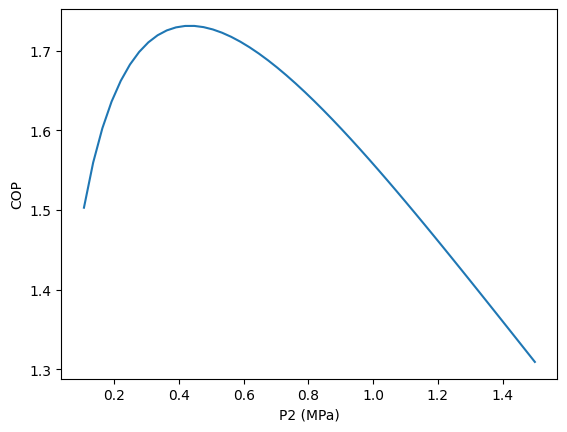

In [ ]:
import numpy as np
from matplotlib.pyplot import plot, xlabel, ylabel, title, show
import CoolProp.CoolProp as CP

# Valores fixados
refri1 = 'R717'  # Ciclo superior
refri2 = 'R134a'  # Ciclo inferior
carga_termica = 1222  # Carga térmica em Watts
delta_T = 5  # Diferença de temperatura no trocador cascata
T_cond = 50 + 273.15  # Temperatura de condensação
efi = 0.7 # Eficiência Isentrópica do Compressor
T_evap = -25 + 273.15 # Temperatura de evaporação

# Intervalo de valores de P2
valores_p2 = np.linspace(106399, 1500000, 50)  # De 1 MPa a 2 MPa

# Armazenamento dos valores
valores_COP = []
pressoes_p2 = []

# Loop para diferentes valores de P2
for P_2 in valores_p2:
    # Ponto 1 (entrada do compressor 1)
    h_1 = CP.PropsSI('H', 'T', T_evap, 'Q', 1, refri2)
    s_1 = CP.PropsSI('S', 'T', T_evap, 'Q', 1, refri2)

    # Ponto 2 (saída do compressor 1)
    h_2s = CP.PropsSI('H', 'P', P_2, 'S', s_1, refri2)
    h_2 = ((h_2s - h_1) / efi) + h_1
    Temperatura_2 = CP.PropsSI('T', 'P', P_2, 'H', h_2, refri2)
    s_2 = CP.PropsSI('S', 'P', P_2, 'H', h_2, refri2)

    # Ponto 3 (saída do trocador cascata)
    h_3 = CP.PropsSI('H', 'P', P_2, 'Q', 0, refri2)
    Temperatura_3 = CP.PropsSI('T', 'P', P_2, 'Q', 0, refri2)
    s_3 = CP.PropsSI('S', 'P', P_2, 'Q', 0, refri2)

    # Ponto 4 (saída da válvula inferior)
    h_4 = h_3

    # Ponto 5 (entrada do compressor 2)
    Temperatura_5 = Temperatura_3 - delta_T
    h_5 = CP.PropsSI('H', 'T', Temperatura_5, 'Q', 1, refri1)
    P_5 = CP.PropsSI('P', 'T', Temperatura_5, 'Q', 1, refri1)
    s_5 = CP.PropsSI('S', 'T', Temperatura_5, 'Q', 1, refri1)

    # Ponto 7 (saída do condensador)
    P_7 = CP.PropsSI('P', 'T', T_cond, 'Q', 0, refri1)
    h_7 = CP.PropsSI('H', 'T', T_cond, 'Q', 0, refri1)

    # Ponto 6 (saída do compressor 2)
    s_6s = s_5
    h_6s = CP.PropsSI('H', 'P', P_7, 'S', s_6s, refri1)
    h_6 = ((h_6s - h_5) / efi) + h_5

    # Ponto 8 (saída da válvula 2)
    h_8 = h_7
    P_8 = P_5
    Temperatura_8 = CP.PropsSI('T', 'P', P_8, 'H', h_8, refri1)
    s_8 = CP.PropsSI('S', 'P', P_8, 'H', h_8, refri1)

    # Cálculo das vazões mássicas
    m1 = carga_termica / (h_1 - h_4)
    m2 = m1 * ((h_3 - h_2) / (h_8 - h_5))

    # Trabalhos e COP
    w1 = m1 * (h_2 - h_1)
    w2 = m2 * (h_6 - h_5)
    COP = carga_termica / (w1 + w2)

    # Cálculo da diferença de temperatura média logarítmica (LMTD)
    delta_T_m = (((Temperatura_2 - Temperatura_8) - (Temperatura_3 - Temperatura_5)) /
                 np.log((Temperatura_2 - Temperatura_8) / (Temperatura_3 - Temperatura_5)))

    # Cálculo de Q
    Q = m2 * (h_5 - h_8)  # Calor trocado no ciclo superior

    # Cálculo de UA
    UA = Q / delta_T_m

    valores_COP.append(COP)
    pressoes_p2.append(P_2 / 1e6)  # Convertendo para MPa

# Plot do gráfico
plot(pressoes_p2, valores_COP, label='COP vs P2')

# Configurações do gráfico
xlabel('P2 (MPa)')
ylabel('COP')
show()

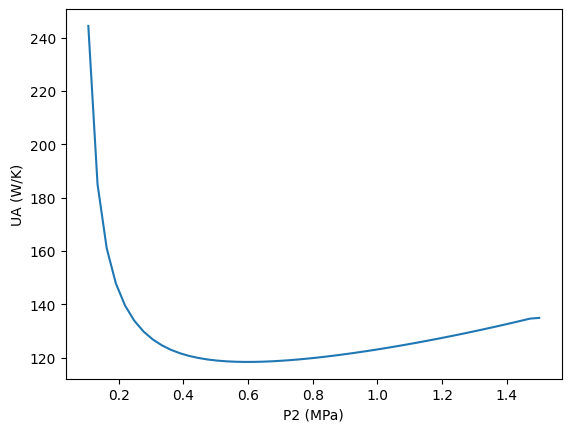

In [ ]:
import numpy as np
from matplotlib.pyplot import plot, xlabel, ylabel, title, show
import CoolProp.CoolProp as CP

# Valores fixados
refri1 = 'R717'  # Ciclo superior
refri2 = 'R134a'  # Ciclo inferior
carga_termica = 1222  # Carga térmica em Watts
delta_T = 5  # Diferença de temperatura no trocador cascata
T_cond = 50 + 273.15  # Temperatura de condensação
efi = 0.7 # Eficiência Isentrópica do Compressor
T_evap = -25 + 273.15 # Temperatura de evaporação

# Intervalo de valores de P2
valores_p2 = np.linspace(106399, 1500000, 50)  # De 1 MPa a 2 MPa

# Armazenamento dos valores
valores_UA = []
pressoes_p2 = []

# Loop para diferentes valores de P2
for P_2 in valores_p2:
    # Ponto 1 (entrada do compressor 1)
    h_1 = CP.PropsSI('H', 'T', T_evap, 'Q', 1, refri2)
    s_1 = CP.PropsSI('S', 'T', T_evap, 'Q', 1, refri2)

    # Ponto 2 (saída do compressor 1)
    h_2s = CP.PropsSI('H', 'P', P_2, 'S', s_1, refri2)
    h_2 = ((h_2s - h_1) / efi) + h_1
    Temperatura_2 = CP.PropsSI('T', 'P', P_2, 'H', h_2, refri2)
    s_2 = CP.PropsSI('S', 'P', P_2, 'H', h_2, refri2)

    # Ponto 3 (saída do trocador cascata)
    h_3 = CP.PropsSI('H', 'P', P_2, 'Q', 0, refri2)
    Temperatura_3 = CP.PropsSI('T', 'P', P_2, 'Q', 0, refri2)
    s_3 = CP.PropsSI('S', 'P', P_2, 'Q', 0, refri2)

    # Ponto 4 (saída da válvula inferior)
    h_4 = h_3

    # Ponto 5 (entrada do compressor 2)
    Temperatura_5 = Temperatura_3 - delta_T
    h_5 = CP.PropsSI('H', 'T', Temperatura_5, 'Q', 1, refri1)
    P_5 = CP.PropsSI('P', 'T', Temperatura_5, 'Q', 1, refri1)
    s_5 = CP.PropsSI('S', 'T', Temperatura_5, 'Q', 1, refri1)

    # Ponto 7 (saída do condensador)
    P_7 = CP.PropsSI('P', 'T', T_cond, 'Q', 0, refri1)
    h_7 = CP.PropsSI('H', 'T', T_cond, 'Q', 0, refri1)

    # Ponto 6 (saída do compressor 2)
    s_6s = s_5
    h_6s = CP.PropsSI('H', 'P', P_7, 'S', s_6s, refri1)
    h_6 = ((h_6s - h_5) / efi) + h_5

    # Ponto 8 (saída da válvula 2)
    h_8 = h_7
    P_8 = P_5
    Temperatura_8 = CP.PropsSI('T', 'P', P_8, 'H', h_8, refri1)
    s_8 = CP.PropsSI('S', 'P', P_8, 'H', h_8, refri1)

    # Cálculo das vazões mássicas
    m1 = carga_termica / (h_1 - h_4)
    m2 = m1 * ((h_3 - h_2) / (h_8 - h_5))

    # Trabalhos e COP
    w1 = m1 * (h_2 - h_1)
    w2 = m2 * (h_6 - h_5)
    COP = carga_termica / (w1 + w2)

    # Cálculo da diferença de temperatura média logarítmica (LMTD)
    delta_T_m = (((Temperatura_2 - Temperatura_8) - (Temperatura_3 - Temperatura_5)) /
                 np.log((Temperatura_2 - Temperatura_8) / (Temperatura_3 - Temperatura_5)))

    # Cálculo de Q
    Q = m2 * (h_5 - h_8)  # Calor trocado no ciclo superior

    # Cálculo de UA
    UA = Q / delta_T_m

    valores_UA.append(UA)
    pressoes_p2.append(P_2 / 1e6)  # Convertendo para MPa

# Plot do gráfico
plot(pressoes_p2, valores_UA, label='UA vs P2')

# Configurações do gráfico
xlabel('P2 (MPa)')
ylabel('UA (W/K)')
show()

In [ ]:
import numpy as np
from matplotlib.pyplot import plot, xlabel, ylabel, title, show
import CoolProp.CoolProp as CP

# Valores fixados
refri1 = 'R717'  # Ciclo superior
refri2 = 'R134a'  # Ciclo inferior
carga_termica = 1222  # Carga térmica em Watts
delta_T = 5  # Diferença de temperatura no trocador cascata
T_cond = 50 + 273.15  # Temperatura de condensação
efi = 0.7 # Eficiência Isentrópica do Compressor
T_evap = -25 + 273.15 # Temperatura de evaporação

# Intervalo de valores de P2
valores_p2 = np.linspace(106399, 1500000, 50)  # De 1 MPa a 2 MPa

# Armazenamento dos valores
valores_UA = []
pressoes_p2 = []

# Loop para diferentes valores de P2
for P_2 in valores_p2:
    # Ponto 1 (entrada do compressor 1)
    h_1 = CP.PropsSI('H', 'T', T_evap, 'Q', 1, refri2)
    s_1 = CP.PropsSI('S', 'T', T_evap, 'Q', 1, refri2)

    # Ponto 2 (saída do compressor 1)
    h_2s = CP.PropsSI('H', 'P', P_2, 'S', s_1, refri2)
    h_2 = ((h_2s - h_1) / efi) + h_1
    Temperatura_2 = CP.PropsSI('T', 'P', P_2, 'H', h_2, refri2)
    s_2 = CP.PropsSI('S', 'P', P_2, 'H', h_2, refri2)

    # Ponto 3 (saída do trocador cascata)
    h_3 = CP.PropsSI('H', 'P', P_2, 'Q', 0, refri2)
    Temperatura_3 = CP.PropsSI('T', 'P', P_2, 'Q', 0, refri2)
    s_3 = CP.PropsSI('S', 'P', P_2, 'Q', 0, refri2)

    # Ponto 4 (saída da válvula inferior)
    h_4 = h_3

    # Ponto 5 (entrada do compressor 2)
    Temperatura_5 = Temperatura_3 - delta_T
    h_5 = CP.PropsSI('H', 'T', Temperatura_5, 'Q', 1, refri1)
    P_5 = CP.PropsSI('P', 'T', Temperatura_5, 'Q', 1, refri1)
    s_5 = CP.PropsSI('S', 'T', Temperatura_5, 'Q', 1, refri1)

    # Ponto 7 (saída do condensador)
    P_7 = CP.PropsSI('P', 'T', T_cond, 'Q', 0, refri1)
    h_7 = CP.PropsSI('H', 'T', T_cond, 'Q', 0, refri1)

    # Ponto 6 (saída do compressor 2)
    s_6s = s_5
    h_6s = CP.PropsSI('H', 'P', P_7, 'S', s_6s, refri1)
    h_6 = ((h_6s - h_5) / efi) + h_5

    # Ponto 8 (saída da válvula 2)
    h_8 = h_7
    P_8 = P_5
    Temperatura_8 = CP.PropsSI('T', 'P', P_8, 'H', h_8, refri1)
    s_8 = CP.PropsSI('S', 'P', P_8, 'H', h_8, refri1)

    # Cálculo das vazões mássicas
    m1 = carga_termica / (h_1 - h_4)
    m2 = m1 * ((h_3 - h_2) / (h_8 - h_5))

    # Trabalhos e COP
    w1 = m1 * (h_2 - h_1)
    w2 = m2 * (h_6 - h_5)
    COP = carga_termica / (w1 + w2)

    # Cálculo da diferença de temperatura média logarítmica (LMTD)
    delta_T_m = (((Temperatura_2 - Temperatura_8) - (Temperatura_3 - Temperatura_5)) /
                 np.log((Temperatura_2 - Temperatura_8) / (Temperatura_3 - Temperatura_5)))

    # Cálculo de Q
    Q = m2 * (h_5 - h_8)  # Calor trocado no ciclo superior

    # Cálculo de UA
    UA = Q / delta_T_m

    # Destruicao de exergia
    t0 = 30 + 273.15  # Temperatura ambiente em K
    tl = -16 + 273.15 # Temperatura do ambiente refrigerado
    ADTot = (w1+w2)+(carga_termica*(1-(t0/tl)))
    valores_UA.append(ADTot)
    pressoes_p2.append(P_2 / 1e6)  # Convertendo para MPa

# Plot do gráfico
plot(pressoes_p2, valores_UA, label=' Exergia Destruída Total vs P2')
import numpy as np

# Encontrar o índice do menor valor de exergia destruída total
min_index = np.argmin(valores_UA)

# Obter os valores correspondentes de P2 e exergia destruída
P2_min = pressoes_p2[min_index]
UA_min = valores_UA[min_index]

# Exibir o resultado
print(f"Ponto mínimo: P2 = {P2_min:.4f} MPa, Exergia Destruída Total = {UA_min:.4f} W")

# Configurações do gráfico
xlabel('P2 (MPa)')
ylabel('Exergia Destruída Total (W)')
show()

ModuleNotFoundError: No module named 'CoolProp'

In [ ]:
import CoolProp.CoolProp as CP
import numpy as np

# Valores fixados
refri1 = 'R717'  # Ciclo superior
refri2 = 'R134a'  # Ciclo inferior
carga_termica = 1222  # Carga térmica em Watts
delta_T = 5  # Diferença de temperatura no trocador cascata
T_cond = 50 + 273.15  # Temperatura de condensação
efi = 0.7 # Eficiência Isentrópica do Compressor
T_evap = -25 + 273.15 # Temperatura de evaporação
tl = -16 + 273.15 # Temperatura do ambiente refrigerado
P_2 = 433890 # P2 ótimo em Pa

# Dados do estado "0"
t0 = 30 + 273.15  # Temperatura ambiente em K
h0_2 = CP.PropsSI('H', 'T', t0, 'P', 101325, refri2)
s0_2 = CP.PropsSI('S', 'T', t0, 'P', 101325, refri2)
h0_1 = CP.PropsSI('H', 'T', t0, 'P', 101325, refri1)
s0_1 = CP.PropsSI('S', 'T', t0, 'P', 101325, refri1)

# Ponto 1 (entrada do compressor 1)
P_1 = CP.PropsSI('P', 'T', T_evap, 'Q', 1, refri2)
h_1 = CP.PropsSI('H', 'T', T_evap, 'Q', 1, refri2)
s_1 = CP.PropsSI('S', 'T', T_evap, 'Q', 1, refri2)
af1 = (h_1 - h0_2) - (t0 * (s_1 - s0_2))

# Ponto 2 (saída do compressor 1)
h_2s = CP.PropsSI('H', 'P', P_2, 'S', s_1, refri2)
h_2 = ((h_2s - h_1) / efi) + h_1
Temperatura_2 = CP.PropsSI('T', 'P', P_2, 'H', h_2, refri2)
s_2 = CP.PropsSI('S', 'P', P_2, 'H', h_2, refri2)
af2 = (h_2 - h0_2) - (t0 * (s_2 - s0_2))

# Ponto 3 (saída do trocador cascata)
h_3 = CP.PropsSI('H', 'P', P_2, 'Q', 0, refri2)
Temperatura_3 = CP.PropsSI('T', 'P', P_2, 'Q', 0, refri2)
s_3 = CP.PropsSI('S', 'P', P_2, 'Q', 0, refri2)
af3 = (h_3 - h0_2) - (t0 * (s_3 - s0_2))

# Ponto 4 (saída da válvula inferior)
h_4 = h_3
s_4 = CP.PropsSI('S', 'P', P_1, 'H', h_4, refri2)
af4 = (h_4 - h0_2) - (t0 * (s_4 - s0_2))

# Ponto 5 (entrada do compressor 2)
Temperatura_5 = Temperatura_3 - delta_T
h_5 = CP.PropsSI('H', 'T', Temperatura_5, 'Q', 1, refri1)
P_5 = CP.PropsSI('P', 'T', Temperatura_5, 'Q', 1, refri1)
s_5 = CP.PropsSI('S', 'T', Temperatura_5, 'Q', 1, refri1)
af5 = (h_5 - h0_1) - (t0 * (s_5 - s0_1))

# Ponto 7 (saída do condensador)
P_7 = CP.PropsSI('P', 'T', T_cond, 'Q', 0, refri1)
h_7 = CP.PropsSI('H', 'T', T_cond, 'Q', 0, refri1)
s_7 = CP.PropsSI('S', 'T', T_cond, 'Q', 0, refri1)
af7 = (h_7 - h0_1) - (t0 * (s_7 - s0_1))

# Ponto 6 (saída do compressor 2)
s_6s = s_5
h_6s = CP.PropsSI('H', 'P', P_7, 'S', s_6s, refri1)
h_6 = ((h_6s - h_5) / efi) + h_5
s_6 = CP.PropsSI('S', 'P', P_7, 'H', h_6, refri1)
af6 = (h_6 - h0_1) - (t0 * (s_6 - s0_1))

# Ponto 8 (saída da válvula 2)
h_8 = h_7
P_8 = P_5
Temperatura_8 = CP.PropsSI('T', 'P', P_8, 'H', h_8, refri1)
s_8 = CP.PropsSI('S', 'P', P_8, 'H', h_8, refri1)
af8 = (h_8 - h0_1) - (t0 * (s_8 - s0_1))

# Cálculo das vazões mássicas
m1 = carga_termica / (h_1 - h_4)
m2 = m1 * ((h_3 - h_2) / (h_8 - h_5))

# Trabalhos e COP
w1 = m1 * (h_2 - h_1)
w2 = m2 * (h_6 - h_5)
COP = carga_termica / (w1 + w2)

# Cálculo da diferença de temperatura média logarítmica (LMTD)
delta_T_m = (((Temperatura_2 - Temperatura_8) - (Temperatura_3 - Temperatura_5)) /
              np.log((Temperatura_2 - Temperatura_8) / (Temperatura_3 - Temperatura_5)))

# Cálculo de Q
Q = m2 * (h_5 - h_8)  # Calor trocado no ciclo superior

# Cálculo de UA
UA = Q / delta_T_m

# Exergia
ADComp1 = (m1*af1)+w1-(m1*af2)
ADValv1 = m1*(af3-af4)
ADEvap = (m1*af4)+(carga_termica*(1-(t0/tl)))-(m1*af1)
ADTrocCasc = (m1 * (af2 - af3)) + (m2 * (af8 - af5))
ADComp2 = (m2*af5)+w2-(m2*af6)
ADValv2 = m2*(af7-af8)
ADCond = m2*(af6-af7)
destruicao_tot = ADComp1+ADValv1+ADEvap+ADTrocCasc+ADComp2+ADValv2+ADCond

# Teste
w = w1 + w2
xqe = -carga_termica*(1-(t0/tl))

print(w-xqe)
print(destruicao_tot)

print(ADComp1)
print(ADValv1)
print(ADEvap)
print(ADTrocCasc)
print(ADComp2)
print(ADValv2)
print(round(ADCond,1))

487.20050721788107
487.2005072178812
90.89548817572859
31.034592223823164
52.248097324044
34.178832001213536
94.40172291559577
27.97367092290769
156.5
